# Setup

In [ ]:
!pip install qiskit matplotlib

import qiskit
import matplotlib

from qiskit import QuantumCircuit, assemble, Aer, circuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 4.3 MB/s 
     |████████████████████████████████| 19.2 MB 11.6 MB/s 
     |████████████████████████████████| 240 kB 9.2 MB/s 
     |████████████████████████████████| 106 kB 43.1 MB/s 
     |████████████████████████████████| 55 kB 1.1 MB/s 
     |████████████████████████████████| 50 kB 2.5 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 854 kB/s 
     |████████████████████████████████| 943 kB 53.9 MB/s 
     |████████████████████████████████| 4.1 MB 12.3 MB/s 
     |████████████████████████████████| 1.9 MB 42.7 MB/s 
     |████████████████████████████████| 112 kB 49.6 MB/s 
  Created wheel for qiskit: filename=qiskit-0.39.2-py3-none-any.whl size=12226 sha256=4f39770d4515068e6f25a6f370753fb689d3d75e329e00ec9e4931eaa45821e9
  Stored in directory: /root/.cache/pip/wheels/30/dc/90/0ee55

# Hash and De-Hash Operators

We simulate a "hash function" by creating a quantum gate that does a one-to-one linear transformation mapping from one four-qubit state (input bit + 3-bit nonce) to another. We also code its inverse, which is needed for Grover's.

In [ ]:
def hash_operator():
  hash_gate = Operator([
    [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0],
    [0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
  ])
  hash_gate.name = "Hash Gate"
  return hash_gate

def dehash_operator():
  hash_dagger = hash_operator().conjugate().transpose()
  hash_dagger.name = "Hash Dagger"
  return hash_dagger

# Oracle

Since the desired hash output is 00xx (x = don't care), we put X-gates around a CZ gate for the 2 most significant bits.

In [ ]:
def oracle():
  qreg_q = QuantumRegister(4, 'q')
  oracle = QuantumCircuit(qreg_q, name='oracle')
  oracle.x(qreg_q[2:4])
  oracle.cz(qreg_q[2], qreg_q[3])
  oracle.x(qreg_q[2:4])
  oracle_op = oracle.to_gate()
  oracle_op.name = 'oracle'
  return oracle

oracle().draw()

q_0: ─────────────
                  
q_1: ─────────────
     ┌───┐   ┌───┐
q_2: ┤ X ├─■─┤ X ├
     ├───┤ │ ├───┤
q_3: ┤ X ├─■─┤ X ├
     └───┘   └───┘

# Diffuser

A diffusor amplifies the magnitude of the ideal states and dampens the magnitude of the undesired states.

In [ ]:
# diffuser from https://qiskit.org/textbook/ch-algorithms/grover.html
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "diffusor"
    return U_s

# Four-block Grover's

Since our algorithm is hypothesized to run in $O(2^{n/2})$ time, we need $\lceil 2^{4/2} \rceil = 4$ blocks.

In [ ]:
n_qubits = 4
controls = QuantumRegister(n_qubits)
circuit = QuantumCircuit(controls)

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

#circuit.measure_all()
circuit.draw()

┌──────────┐┌─────────┐┌──────────┐┌───────────┐
q0_0: ┤0         ├┤0        ├┤0         ├┤0          ├
      │          ││         ││          ││           │
q0_1: ┤1         ├┤1        ├┤1         ├┤1          ├
      │  Unitary ││  oracle ││  Unitary ││  diffusor │
q0_2: ┤2         ├┤2        ├┤2         ├┤2          ├
      │          ││         ││          ││           │
q0_3: ┤3         ├┤3        ├┤3         ├┤3          ├
      └──────────┘└─────────┘└──────────┘└───────────┘

#Building the Circuit
Let's first try input = 0.

In [ ]:
n_qubits = 4
controls = QuantumRegister(n_qubits)
circuit = QuantumCircuit(controls)

#input 0
circuit.i(3)

#Create uniform superposition of possible nonces
circuit.h([0,1,2])

#Run Grover's 2^(4/2) times
circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.measure_all()
circuit.draw()

┌───┐┌──────────┐┌─────────┐┌──────────┐┌───────────┐┌──────────┐»
  q1_0: ┤ H ├┤0         ├┤0        ├┤0         ├┤0          ├┤0         ├»
        ├───┤│          ││         ││          ││           ││          │»
  q1_1: ┤ H ├┤1         ├┤1        ├┤1         ├┤1          ├┤1         ├»
        ├───┤│  Unitary ││  oracle ││  Unitary ││  diffusor ││  Unitary │»
  q1_2: ┤ H ├┤2         ├┤2        ├┤2         ├┤2          ├┤2         ├»
        ├───┤│          ││         ││          ││           ││          │»
  q1_3: ┤ I ├┤3         ├┤3        ├┤3         ├┤3          ├┤3         ├»
        └───┘└──────────┘└─────────┘└──────────┘└───────────┘└──────────┘»
meas_0: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_1: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_2: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_3: ═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌─────────┐┌──────────┐┌───────────┐┌──────────┐┌─────────┐»
«  q1_0: ┤0        ├┤0         ├┤0          ├┤0         ├┤0        ├»
«        │         ││          ││           ││          ││         │»
«  q1_1: ┤1        ├┤1         ├┤1          ├┤1         ├┤1        ├»
«        │  oracle ││  Unitary ││  diffusor ││  Unitary ││  oracle │»
«  q1_2: ┤2        ├┤2         ├┤2          ├┤2         ├┤2        ├»
«        │         ││          ││           ││          ││         │»
«  q1_3: ┤3        ├┤3         ├┤3          ├┤3         ├┤3        ├»
«        └─────────┘└──────────┘└───────────┘└──────────┘└─────────┘»
«meas_0: ═══════════════════════════════════════════════════════════»
«                                                                   »
«meas_1: ═══════════════════════════════════════════════════════════»
«                                                                   »
«meas_2: ═══════════════════════════════════════════════════════════»
«                                                                   »
«meas_3: ═══════════════════════════════════════════════════════════»
«                                                                   »
«        ┌──────────┐┌───────────┐┌──────────┐┌─────────┐┌──────────┐»
«  q1_0: ┤0         ├┤0          ├┤0         ├┤0        ├┤0         ├»
«        │          ││           ││          ││         ││          │»
«  q1_1: ┤1         ├┤1          ├┤1         ├┤1        ├┤1         ├»
«        │  Unitary ││  diffusor ││  Unitary ││  oracle ││  Unitary │»
«  q1_2: ┤2         ├┤2          ├┤2         ├┤2        ├┤2         ├»
«        │          ││           ││          ││         ││          │»
«  q1_3: ┤3         ├┤3          ├┤3         ├┤3        ├┤3         ├»
«        └──────────┘└───────────┘└──────────┘└─────────┘└──────────┘»
«meas_0: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_1: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_2: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_3: ════════════════════════════════════════════════════════════»
«                                                                    »
«        ┌───────────┐ ░ ┌─┐         
«  q1_0: ┤0          ├─░─┤M├─────────
«        │           │ ░ └╥┘┌─┐      
«  q1_1: ┤1          ├─░──╫─┤M├──────
«        │  diffusor │ ░  ║ └╥┘┌─┐   
«  q1_2: ┤2          ├─░──╫──╫─┤M├───
«        │           │ ░  ║  ║ └╥┘┌─┐
«  q1_3: ┤3          ├─░──╫──╫──╫─┤M├
«        └───────────┘ ░  ║  ║  

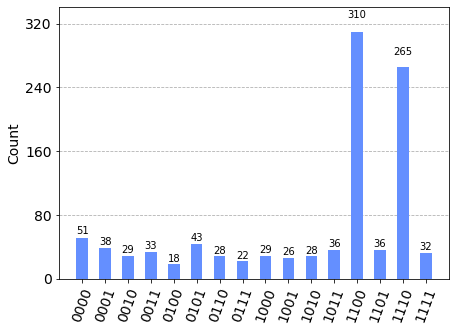

In [ ]:
sim = Aer.get_backend('aer_simulator') 
# We run the simulator with sim.run(QUANTUM CIRCUIT),
# And we get the resulting values with .result()
transpiled_grover_circuit = transpile(circuit, sim)
qobj = assemble(transpiled_grover_circuit)
result = sim.run(qobj).result()
# We then collect the results using .get_counts()
counts = result.get_counts()
# Visualization
plot_histogram(counts)

It seems to be giving the correct nonces for the other input bit, which is quite peculiar. We don't really know why this is happening.

Let's also try input 1:

In [ ]:
n_qubits = 4
controls = QuantumRegister(n_qubits)
circuit = QuantumCircuit(controls)

#input 1
circuit.x(3)

#Create uniform superposition of possible nonces
circuit.h([0,1,2])

#Run Grover's 2^(4/2) times
circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.append(hash_operator(), [0, 1, 2, 3])
circuit.append(oracle(), [0, 1, 2, 3])
circuit.append(dehash_operator(), [0, 1, 2, 3])
circuit.append(diffuser(n_qubits), [0, 1, 2, 3])

circuit.measure_all()
circuit.draw()

┌───┐┌──────────┐┌─────────┐┌──────────┐┌───────────┐┌──────────┐»
 q10_0: ┤ H ├┤0         ├┤0        ├┤0         ├┤0          ├┤0         ├»
        ├───┤│          ││         ││          ││           ││          │»
 q10_1: ┤ H ├┤1         ├┤1        ├┤1         ├┤1          ├┤1         ├»
        ├───┤│  Unitary ││  oracle ││  Unitary ││  diffusor ││  Unitary │»
 q10_2: ┤ H ├┤2         ├┤2        ├┤2         ├┤2          ├┤2         ├»
        ├───┤│          ││         ││          ││           ││          │»
 q10_3: ┤ X ├┤3         ├┤3        ├┤3         ├┤3          ├┤3         ├»
        └───┘└──────────┘└─────────┘└──────────┘└───────────┘└──────────┘»
meas_0: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_1: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_2: ═════════════════════════════════════════════════════════════════»
                                                                         »
meas_3: ═════════════════════════════════════════════════════════════════»
                                                                         »
«        ┌─────────┐┌──────────┐┌───────────┐┌──────────┐┌─────────┐»
« q10_0: ┤0        ├┤0         ├┤0          ├┤0         ├┤0        ├»
«        │         ││          ││           ││          ││         │»
« q10_1: ┤1        ├┤1         ├┤1          ├┤1         ├┤1        ├»
«        │  oracle ││  Unitary ││  diffusor ││  Unitary ││  oracle │»
« q10_2: ┤2        ├┤2         ├┤2          ├┤2         ├┤2        ├»
«        │         ││          ││           ││          ││         │»
« q10_3: ┤3        ├┤3         ├┤3          ├┤3         ├┤3        ├»
«        └─────────┘└──────────┘└───────────┘└──────────┘└─────────┘»
«meas_0: ═══════════════════════════════════════════════════════════»
«                                                                   »
«meas_1: ═══════════════════════════════════════════════════════════»
«                                                                   »
«meas_2: ═══════════════════════════════════════════════════════════»
«                                                                   »
«meas_3: ═══════════════════════════════════════════════════════════»
«                                                                   »
«        ┌──────────┐┌───────────┐┌──────────┐┌─────────┐┌──────────┐»
« q10_0: ┤0         ├┤0          ├┤0         ├┤0        ├┤0         ├»
«        │          ││           ││          ││         ││          │»
« q10_1: ┤1         ├┤1          ├┤1         ├┤1        ├┤1         ├»
«        │  Unitary ││  diffusor ││  Unitary ││  oracle ││  Unitary │»
« q10_2: ┤2         ├┤2          ├┤2         ├┤2        ├┤2         ├»
«        │          ││           ││          ││         ││          │»
« q10_3: ┤3         ├┤3          ├┤3         ├┤3        ├┤3         ├»
«        └──────────┘└───────────┘└──────────┘└─────────┘└──────────┘»
«meas_0: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_1: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_2: ════════════════════════════════════════════════════════════»
«                                                                    »
«meas_3: ════════════════════════════════════════════════════════════»
«                                                                    »
«        ┌───────────┐ ░ ┌─┐         
« q10_0: ┤0          ├─░─┤M├─────────
«        │           │ ░ └╥┘┌─┐      
« q10_1: ┤1          ├─░──╫─┤M├──────
«        │  diffusor │ ░  ║ └╥┘┌─┐   
« q10_2: ┤2          ├─░──╫──╫─┤M├───
«        │           │ ░  ║  ║ └╥┘┌─┐
« q10_3: ┤3          ├─░──╫──╫──╫─┤M├
«        └───────────┘ ░  ║  ║  

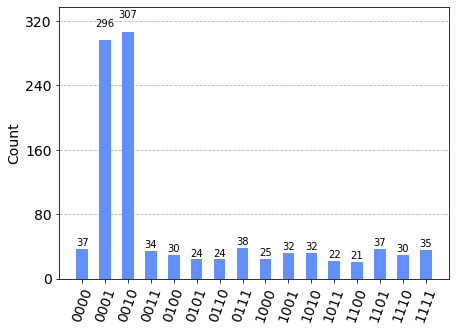

In [ ]:
sim = Aer.get_backend('aer_simulator') 
# We run the simulator with sim.run(QUANTUM CIRCUIT),
# And we get the resulting values with .result()
transpiled_grover_circuit = transpile(circuit, sim)
qobj = assemble(transpiled_grover_circuit)
result = sim.run(qobj).result()
# We then collect the results using .get_counts()
counts = result.get_counts()
# Visualization
plot_histogram(counts)